# P6 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">

**Delivery**

<ol>
Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.
    <li>  The implemented code should be,<br>
        - free of errors (Run All before delivery and check for possible errors)<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions      
    <li> The deliverable must be a file named P6_Student1_Student2.zip that includes:
    <ul>
        <li> The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
         <li> All the images used in this notebook.
    </ul>

</ul>

 **Deadline (Campus Virtual): November 11th, 23:00 h** 


</ol>
</div>

## Face recognition

The main topics of this notebook are:

- Face recognition problem
- Eigenfaces

We work with the code of a face recognition algorithm using sckit-learn (Source [here](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py)) and an out-of-the-box dataset by the University of Massachusetts called Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)). Scikit-learn can automatically load the dataset in the correct format. Read the code and do the exercises below.


In [80]:
from time import time
import logging
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [15]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f'Total dataset size:')
print(f'n_samples:  {n_samples}')
print(f'n_features: {n_features}')
print(f'n_classes:  {n_classes}')

Total dataset size:
n_samples:  1288
n_features: 1850
n_classes:  7


In [16]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print(f'Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces.')
ts = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print(f'- Done in {time() - ts:.3f}s\n')

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
ts = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f'- Done in {time() - ts:.3f}s')

Extracting the top 100 eigenfaces from 966 faces.
- Done in 0.099s

Projecting the input data on the eigenfaces orthonormal basis
- Done in 0.009s


In [38]:
# #############################################################################
# Train a SVM classification model

print('Fitting the classifier to the training set')

ts = time()
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}

clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'),
    param_grid=param_grid, cv=5, iid=False)

clf = clf.fit(X_train_pca, y_train)

print(f'- Done in {time() - ts:.3f}')
print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
- Done in 28.176
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [40]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print('Predicting people\'s names on the test set')

ts = time()
y_pred = clf.predict(X_test_pca)

print(f'- Done in {time() - ts}')

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
- Done in 0.03523135185241699
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.81      0.92      0.86        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.90      0.95      0.92       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.88      0.78      0.82        36

        micro avg       0.86      0.86      0.86       322
        macro avg       0.84      0.77      0.80       322
     weighted avg       0.87      0.86      0.86       322

[[  9   1   2   1   0   0   0]
 [  0  55   0   4   0   1   0]
 [  3   2  18   4   0   0   0]
 [  1   4   1 139   0   0   1]
 [  0   1   0   2  20   0   2]
 [  0   3   0   1   1   9   1]
 [  1   2   1   4   0   0  28]]


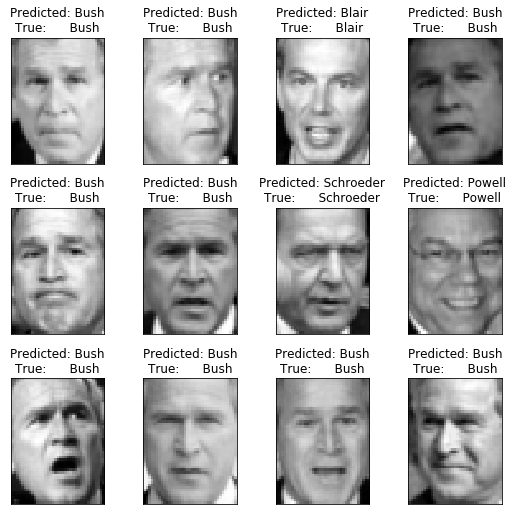

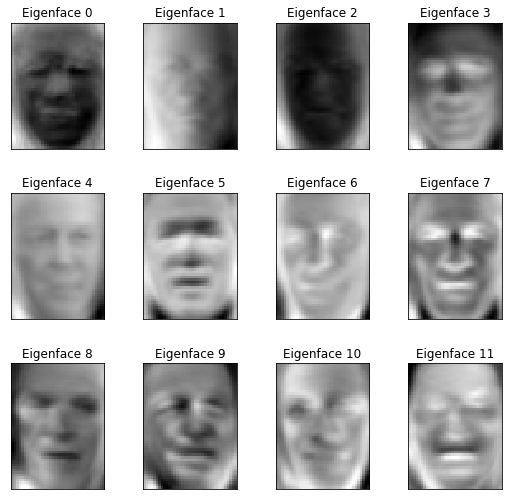

In [42]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return f'Predicted: {pred_name}\nTrue:      {true_name}'


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


# plot the gallery of the most significative eigenfaces

eigenface_titles = [f'Eigenface {i}' for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

**Exercise 1:**

Show the total percentage of variance explained by the selected components of the PCA.

Variance explained with 100 components = 0.9282108545303345


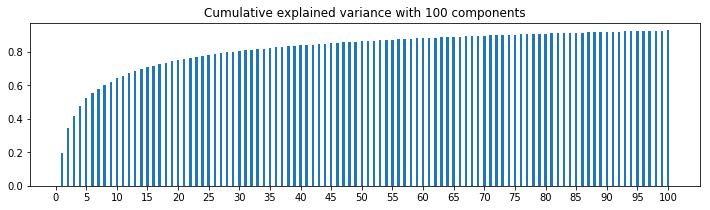

In [74]:
var_explained = pca.explained_variance_ratio_.cumsum()
print(f'Variance explained with {pca.n_components} components = {var_explained[-1]}')

plt.figure(figsize=(12, 3))
plt.bar(list(range(1, 101)), var_explained, width=0.4)
plt.title(f'Cumulative explained variance with {pca.n_components} components')
plt.xticks(list(range(0, 101, 5)))
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

`explained_variance_ratio_` returns the percent of variance explained by each component. Performing a cumulative sum the last component (100th) has the variance explained by all of them.

</div>

**Exercise 2** 

- Explain all the measures showed in the classification report.
- Discuss the obtained classification results, the quantitative as well as the qualitative results.
- Comment the showed eigenfaces.

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
Recalling the structure of a confusion matrix
<table style="border: 1px solid black">
    <tr>
        <td style="border-right: solid 1px black; background-color: #00000000"></td>
        <td colspan="2">Predicted</td>
    </tr>
    <tr>
        <td rowspan="2" style="border-right: solid 1px black; border-top: solid 1px black">Actual</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">True Positives (TP)</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">False Positives (FP)</td>
    </tr>
    <tr>
        <td style="border-right: solid 1px black; border-top: solid 1px black">False Negatives (FN)</td>
        <td style="border-right: solid 1px black; border-top: solid 1px black">True Negatives (TN)</td>
    </tr>
</table>
    
`classification_report` builds a metric summary including 4 different metrics:
- Precision: Percentage of the results which are relevant. Ratio of _TP / (TP + FP)_
- Recall: Percentage of total relevant results correctly classified the algorithm, as _TP / (TP + FN)_
- F1-score: Harmonic mean of precission and recall: _2 * (P * R) / (P + R)_
- Support: Number of samples of the true response that lie in that class.

**Quantitative Results**

**Qualitative Results**

</div>

**Exercise 3:**

- Change the strategy for dimensionality reduction from PCA to LDA. You can use `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`.
- How many dimensions are we obtaining in the new space? Why?
- Comment the results and compare them with the ones obtained with PCA.
- Explain which is the main difference between the two approaches.

In [82]:
# TODO: Correlated

print(f'Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces.')
ts = time()
lda = LinearDiscriminantAnalysis(n_components=n_components).fit(X_train, y_train)
print(f'- Done in {time() - ts:.3f}s\n')

# plt.matshow(pd.DataFrame(X_train).corr())
# plt.show()

Extracting the top 100 eigenfaces from 966 faces.
- Done in 0.930s



/Users/josepdecidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [97]:
var_explained = lda.explained_variance_ratio_.cumsum()

print(f'Extracting the top {len(var_explained)} eigenfaces from {X_train.shape[0]} faces.')
print(f'{var_explained[-1]}')

Extracting the top 6 eigenfaces from 966 faces.
0.9999999999999999


<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

</div>